<h2 style='color:blue' align='center'>Data Augmentation To Address Overfitting In Flower Classification CNN</h2>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

We will download flowers dataset from google website and store it locally. In below call it downloads the zip file (.tgz) in cache_dir which is . meaning the current folder

<h3 style='color:purple'>Load flowers dataset</h3>

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

In [3]:
data_dir

'./datasets/flower_photos'

In [4]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [5]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/dandelion/155646858_9a8b5e8fc8.jpg'),
 PosixPath('datasets/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg'),
 PosixPath('datasets/flower_photos/dandelion/8689302980_9bd2f7b9fe_n.jpg'),
 PosixPath('datasets/flower_photos/dandelion/18889216716_cd67aec890_n.jpg'),
 PosixPath('datasets/flower_photos/dandelion/5670543216_8c4cb0caa8_m.jpg')]

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [7]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/3873271620_1d9d314f01_n.jpg'),
 PosixPath('datasets/flower_photos/roses/2471103806_87ba53d997_n.jpg'),
 PosixPath('datasets/flower_photos/roses/14970973709_968910640e_n.jpg'),
 PosixPath('datasets/flower_photos/roses/9159362388_c6f4cf3812_n.jpg'),
 PosixPath('datasets/flower_photos/roses/6363976189_e7155e5f9c.jpg')]

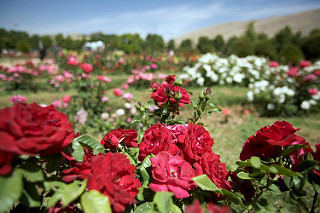

In [8]:
PIL.Image.open(str(roses[1]))

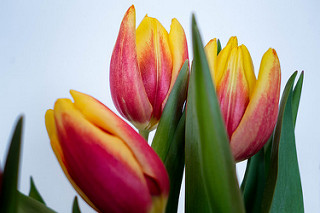

In [9]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

<h3 style='color:purple'>Read flowers images from disk into numpy array using opencv</h3>

In [10]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [11]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [12]:
flowers_images_dict['roses'][:5]

[PosixPath('datasets/flower_photos/roses/3873271620_1d9d314f01_n.jpg'),
 PosixPath('datasets/flower_photos/roses/2471103806_87ba53d997_n.jpg'),
 PosixPath('datasets/flower_photos/roses/14970973709_968910640e_n.jpg'),
 PosixPath('datasets/flower_photos/roses/9159362388_c6f4cf3812_n.jpg'),
 PosixPath('datasets/flower_photos/roses/6363976189_e7155e5f9c.jpg')]

In [13]:
str(flowers_images_dict['roses'][0])

'datasets/flower_photos/roses/3873271620_1d9d314f01_n.jpg'

In [14]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [15]:
img.shape

(222, 320, 3)

In [16]:
cv2.resize(img,(180,180)).shape

(180, 180, 3)

In [17]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [18]:
X = np.array(X)
y = np.array(y)

<h3 style='color:purple'>Train test split</h3>

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

<h3 style='color:purple'>Preprocessing: scale images</h3>

In [20]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [21]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(180,
                                                              180,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

**Original Image**

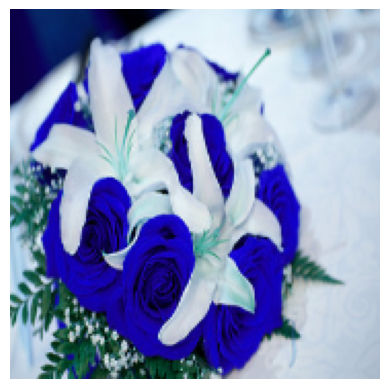

In [22]:
plt.axis('off')
plt.imshow(X[0])

**Newly generated training sample using data augmentation**

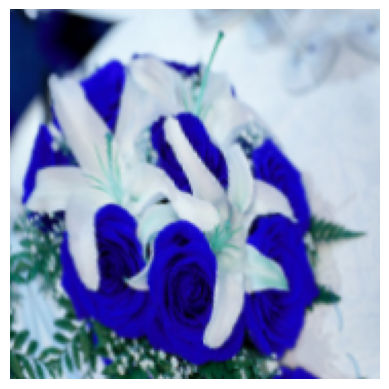

In [23]:
plt.axis('off')
plt.imshow(data_augmentation(X)[0].numpy().astype("uint8"))

<h3 style='color:purple'>Train the model using data augmentation and a drop out layer</h3>

In [24]:
num_classes = 5
model = Sequential([
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
# Define EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)


In [27]:
# Modify fit function to include validation data and callbacks
history = model.fit(X_train_scaled, y_train, epochs=10, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])


Epoch 1/10
86/86 [==============================] - 11s 54ms/step - loss: 1.3191 - accuracy: 0.4397 - val_loss: 1.2114 - val_accuracy: 0.4902
Epoch 2/10
86/86 [==============================] - 4s 43ms/step - loss: 1.0635 - accuracy: 0.5690 - val_loss: 1.0590 - val_accuracy: 0.5686
Epoch 3/10
86/86 [==============================] - 4s 43ms/step - loss: 0.9529 - accuracy: 0.6290 - val_loss: 0.9212 - val_accuracy: 0.6285
Epoch 4/10
86/86 [==============================] - 4s 47ms/step - loss: 0.8806 - accuracy: 0.6642 - val_loss: 0.8742 - val_accuracy: 0.6525
Epoch 5/10
86/86 [==============================] - 4s 42ms/step - loss: 0.8196 - accuracy: 0.6835 - val_loss: 0.8122 - val_accuracy: 0.6732
Epoch 6/10
86/86 [==============================] - 4s 44ms/step - loss: 0.7761 - accuracy: 0.6951 - val_loss: 0.7579 - val_accuracy: 0.7048
Epoch 7/10
86/86 [==============================] - 4s 41ms/step - loss: 0.7602 - accuracy: 0.7068 - val_loss: 0.7669 - val_accuracy: 0.7222
Epoch 8/10
8

In [28]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 0s 10ms/step - loss: 0.7265 - accuracy: 0.7331


[0.7264520525932312, 0.7331154942512512]

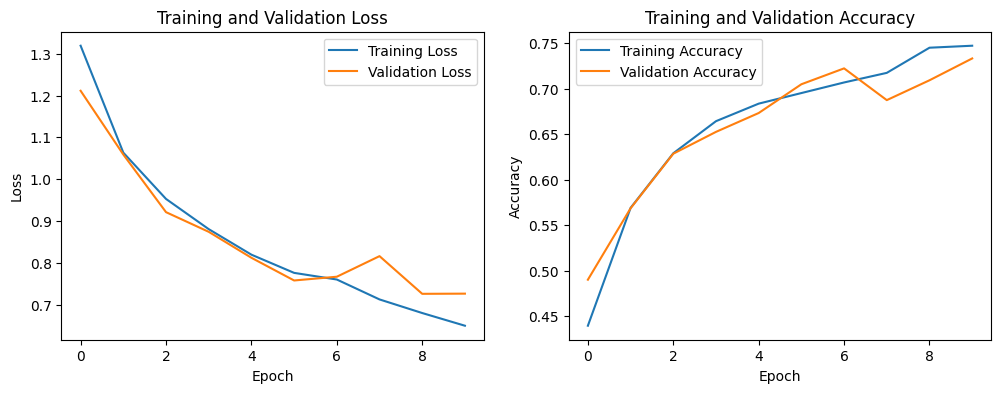

In [29]:
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()